## generate image with random PWM values

The original PWM randomly set by [2459, 438, 2498, 2387, 1937].


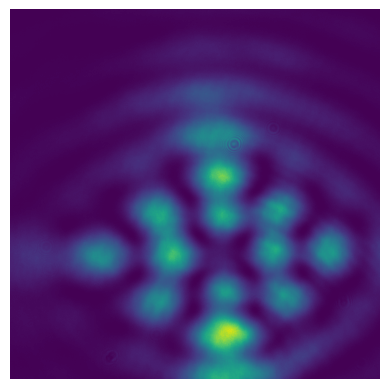

In [1]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
  
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
A = np.random.randint(low=0,high=4095,size=(5,1), dtype=np.int32)   # range form 0 to 3000
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A)
raw_image_array = cam.grab(10) # grab 10 frames
image_array_initial=np.array(raw_image_array)
squeezed_image_array=image_array_initial.squeeze()
random_PWM=A
random_PWM_printed=A.ravel().tolist()
print(f"The original PWM randomly set by {random_PWM_printed}.")
plt.axis('off')
plt.imshow(image_array_initial[0])
cam.close()


In [2]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)
def get_quality_number(squeezed_image_array):
    score=[]
    for i in range (len(squeezed_image_array)):
        x=np.linspace(0,1000,1000)
        [m,n]=np.where(squeezed_image_array[i]==np.max(squeezed_image_array[i]))
        mode_info_m = stats.mode(m, keepdims=True)  ##col
        mode_info_n = stats.mode(n, keepdims=True) ##row
        a=int(mode_info_m[0])
        b=int(mode_info_n[0])
        c=5 #box half-thickness
        y_x=0

        for j in range (a-c,a+c):
            y_x=y_x+squeezed_image_array[i][j,:]/100 #tricky here since if this number is >255 it becomes 0.
        y_x=(y_x)/c*100

        y_y=0

        for j in range (b-c,b+c):
            y_y=y_y+squeezed_image_array[i][:,j]/100
        y_y=((y_y)/c)*100

        popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
        fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
        a_x=r2_score(y_x,fitted_y_x)
        popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
        fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
        a_y=r2_score(y_y,fitted_y_y)

        s=abs(a_x*a_y)
        score.append(s)
        average_score=np.mean(score)
    return average_score

s1=get_quality_number(squeezed_image_array)
print(s1)

0.4023658264452383


In [3]:
def set_PWMs(pwms):
    # Your code that sets the PWMs
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    return 0

In [4]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

In [5]:
def do_annealing(wait=5*33*0.03):
    # Annealing
    with open('PWM_test.csv', 'r', encoding='utf-8') as pwm_file:
        pwm_data = pwm_file.readlines()
    # Write data to do_annealing.csv
    with open('do_annealing.csv', 'w', encoding='utf-8') as annealing_file:
        annealing_file.writelines(pwm_data)
    time.sleep(wait) # Wait for annealing to complete

In [6]:
def get_quality_number1():

    #take image and calculate the quality number
    raw_image_array = cam.grab(10)    # grab 10 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    score=[]
    for i in range (len(squeezed_image_array)):
        x=np.linspace(0,1000,1000)
        [m,n]=np.where(squeezed_image_array[i]==np.max(squeezed_image_array[i]))
        mode_info_m = stats.mode(m, keepdims=True)  ##col
        mode_info_n = stats.mode(n, keepdims=True) ##row
        a=int(mode_info_m[0])
        b=int(mode_info_n[0])
        c=5 #box half-thickness
        y_x=0

        for j in range (max(0,a-c),min(999,a+c)):
            y_x=y_x+squeezed_image_array[i][j,:]/100 #tricky here since if this number is >255 it becomes 0.
        y_x=(y_x)/c*100

        y_y=0

        for j in range (max(0,b-c),min(999,b+c)):
            y_y=y_y+squeezed_image_array[i][:,j]/100
        y_y=((y_y)/c)*100

        popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
        fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
        a_x=r2_score(y_x,fitted_y_x)
        popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
        fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
        a_y=r2_score(y_y,fitted_y_y)

        s=abs(a_x*a_y)
        score.append(s)
        average_score=np.mean(score)
        quality_number = average_score
       
    return quality_number

In [7]:
import laserbeamsize as lbs

def get_quality_number2():
    #take image and calculate the quality number
    raw_image_array = cam.grab(10)    # grab 10 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    score=[]
    for i in range (len(squeezed_image_array)):
        x, y, dx, dy, phi = lbs.beam_size(squeezed_image_array[i])
        denominator = max(dx, dy)
        if denominator == 0 :
            denominator = denominator + 0.000001
        Ellipticity = min(dx, dy) / denominator
        threshold_up_area = (squeezed_image_array[i] >= np.max(squeezed_image_array[i]) / 10) + 0  # define a threshold area
        total_pixel = squeezed_image_array[i].shape[0] * squeezed_image_array[i].shape[1]
        dispersion = total_pixel / np.sum(threshold_up_area)
        quality_number = dispersion * Ellipticity
        score.append(quality_number)
        average_score=np.mean(score)
    return average_score
s2=get_quality_number2()
print(s2)

2.6570392290448943


In [8]:
# SYNTHESIS and CHARACTERISATION
from OptimizationTestFunctions import Sphere, plot_3d
def set_PWMs_and_get_quality(pwms,sphere_test=False, annealing=False):
    if sphere_test:
        f = Sphere(dim=5,degree=2)
        #return -1*f(pwms)
        return -1*f(pwms)/1000000
    else:
        # Zoe fills in above:
        set_PWMs(pwms)
        quality_number = get_quality_number1()
        if annealing:
            do_annealing()
        return quality_number

In [9]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

In [10]:
# Random Strategy

import random

def get_random_PWMs():
    return [random.randint(0, 4095) for _ in range(5)]

random_PWMs = get_random_PWMs()
print(random_PWMs)

[745, 966, 1166, 1704, 1365]


In [11]:
# Bayesian Opt Strategy

import numpy as np
import pandas as pd

from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]), seed=0)
torch.manual_seed(seed=0)  # to keep the restart conditions the same    

def calculate_BO_candidate(samples):
    train_X = samples[["p1","p2","p3","p4","p5"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    #from botorch.acquisition import UpperConfidenceBound
    #UCB = UpperConfidenceBound(gp, beta=.1)

    MC_EI = qExpectedImprovement(gp, best_f=train_Y.max(), sampler=sampler)
    
    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(5), torch.ones(5)*4095])
    #bounds = torch.stack([torch.zeros(5), torch.ones(5)*5])

    candidate, acq_value = optimize_acqf(
        MC_EI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    return candidate

Optimisation Loop:

In [12]:
import random
import pandas as pd
import time

N_TRIALS = 15
N_ITERATIONS = 250
USE_TEST_FUNCTION = False

best_random_all = []
best_BO_all = []
random_trial_samples = []
BO_trial_samples = []



for trial in range(N_TRIALS):
    print(f"Trial {trial}")
    BO_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    random_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    BO_current_candidate = get_random_PWMs()
    random_current_candidate = get_random_PWMs()
    
    best_random = []
    best_BO = []

    for iteration in range(N_ITERATIONS):
        
        #print(f"Iteration {iteration}")
        # Random Search
        random_current_quality = set_PWMs_and_get_quality(random_current_candidate, sphere_test=USE_TEST_FUNCTION)
        new_sample = {f"p{i+1}": p for i, p in enumerate(random_current_candidate)}
        new_sample["error"] = random_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        random_samples = pd.concat([random_samples, new_sample], axis=0, ignore_index=True)
        random_current_candidate = get_random_PWMs()
        
        # Bayesian Optimization
        BO_current_quality = set_PWMs_and_get_quality(BO_current_candidate, sphere_test=USE_TEST_FUNCTION)
        new_sample = {f"p{i+1}": p for i, p in enumerate(BO_current_candidate)}
        new_sample["error"] = BO_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        BO_samples = pd.concat([BO_samples, new_sample], axis=0, ignore_index=True)
        
        if iteration < 10:
            BO_current_candidate = get_random_PWMs()
        else:
            BO_current_candidate = calculate_BO_candidate(BO_samples)
            BO_current_candidate = [torch.round(x) for x in BO_current_candidate]
        
        best_random.append(random_samples["error"].max())
        best_BO.append(BO_samples["error"].max())
        
    random_trial_samples.append(random_samples.copy(deep=True))
    BO_trial_samples.append(BO_samples.copy(deep=True))
    
    best_random_all.append(best_random)
    best_BO_all.append(best_BO)

    # Print the best BO parameters and value for the current trial
    best_BO_value = max(best_BO)
    best_BO_index = best_BO.index(best_BO_value)
    best_BO_params = BO_trial_samples[trial].loc[best_BO_index, ['p1', 'p2', 'p3', 'p4', 'p5']].tolist()
    print(f"Best BO Parameters (Trial {trial}):", best_BO_params)
    print(f"Best BO Value (Trial {trial}):", best_BO_value)
    print("=" * 30)
import pickle
# open a file, where you ant to store the data
filename = 'results_'+str(time.time())
file = open(filename, 'wb')

# dump information to that file
data = (random_trial_samples, BO_trial_samples, best_random_all, best_BO_all)
pickle.dump(data, file)
# close the file
file.close()



Trial 0


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encounte

Best BO Parameters (Trial 0): [tensor(1188.), tensor(674.), tensor(444.), tensor(701.), tensor(981.)]
Best BO Value (Trial 0): 0.9868883982128926
Trial 1


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 1): [tensor(1940.), tensor(3471.), tensor(3362.), tensor(341.), tensor(1498.)]
Best BO Value (Trial 1): 0.978811839520643
Trial 2


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 2): [tensor(410.), tensor(3724.), tensor(1016.), tensor(1424.), tensor(1035.)]
Best BO Value (Trial 2): 0.9851490015221767
Trial 3


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:381: RuntimeWarning: Optimization faile

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


Best BO Parameters (Trial 3): [tensor(1582.), tensor(2177.), tensor(1864.), tensor(3092.), tensor(3385.)]
Best BO Value (Trial 3): 0.9798577961484295
Trial 4


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: overflow encountered in multiply
  pcov = pcov * s_sq
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overfl

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 4): [1187, 421, 1966, 3247, 2735]
Best BO Value (Trial 4): 0.9849250820074271
Trial 5


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 5): [tensor(557.), tensor(3573.), tensor(2026.), tensor(3918.), tensor(3348.)]
Best BO Value (Trial 5): 0.9878147243886708
Trial 6


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 6): [tensor(355.), tensor(876.), tensor(540.), tensor(744.), tensor(386.)]
Best BO Value (Trial 6): 0.9861797591806887
Trial 7


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  

Best BO Parameters (Trial 7): [tensor(598.), tensor(3654.), tensor(2139.), tensor(1303.), tensor(2509.)]
Best BO Value (Trial 7): 0.9852730713821976
Trial 8


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 8): [tensor(419.), tensor(1863.), tensor(589.), tensor(3350.), tensor(2857.)]
Best BO Value (Trial 8): 0.9902870864962642
Trial 9


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 9): [tensor(833.), tensor(819.), tensor(1906.), tensor(2736.), tensor(2156.)]
Best BO Value (Trial 9): 0.9927458542356524
Trial 10


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: overflow encountered in multiply
  pcov = pcov * s_sq
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overfl

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 10): [tensor(523.), tensor(2622.), tensor(959.), tensor(708.), tensor(868.)]
Best BO Value (Trial 10): 0.9868333672882474
Trial 11


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are bein

Best BO Parameters (Trial 11): [tensor(780.), tensor(23.), tensor(3893.), tensor(3826.), tensor(282.)]
Best BO Value (Trial 11): 0.9837065990142919
Trial 12


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Use

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 12): [tensor(334.), tensor(2565.), tensor(3876.), tensor(3720.), tensor(1316.)]
Best BO Value (Trial 12): 0.9905104379684762
Trial 13


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acq

Best BO Parameters (Trial 13): [tensor(1963.), tensor(1636.), tensor(1183.), tensor(855.), tensor(2928.)]
Best BO Value (Trial 13): 0.9893365409225663
Trial 14


C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Users\plasma\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overf

Best BO Parameters (Trial 14): [tensor(1199.), tensor(1160.), tensor(953.), tensor(880.), tensor(200.)]
Best BO Value (Trial 14): 0.9871309386595118


In [13]:
BO_trial_samples

[                p1             p2             p3             p4  \
 0             3788           3555           2066           2218   
 1             3664           4002           2012             29   
 2             2169           3191           1942           3823   
 3             2831           2049           3125           3211   
 4             2975           1861           1908            265   
 ..             ...            ...            ...            ...   
 245  tensor(3291.)   tensor(669.)  tensor(1322.)   tensor(528.)   
 246   tensor(757.)  tensor(1208.)  tensor(3110.)  tensor(1888.)   
 247  tensor(1447.)    tensor(93.)   tensor(436.)  tensor(1190.)   
 248  tensor(3044.)   tensor(256.)   tensor(150.)  tensor(3809.)   
 249  tensor(2681.)  tensor(1411.)  tensor(3871.)  tensor(3601.)   
 
                 p5     error trial iteration     timestamp  
 0             1867  0.719943     0         0  1.692307e+09  
 1              828  0.058458     0         1  1.692307e+0

In [14]:
best_BO_all

[[0.719943036644123,
  0.719943036644123,
  0.868221481290947,
  0.868221481290947,
  0.868221481290947,
  0.868221481290947,
  0.8865349610112812,
  0.8865349610112812,
  0.9276851507800226,
  0.9276851507800226,
  0.9276851507800226,
  0.9276851507800226,
  0.9276851507800226,
  0.9276851507800226,
  0.9517614507338804,
  0.9517614507338804,
  0.9517614507338804,
  0.9517614507338804,
  0.9517614507338804,
  0.9517614507338804,
  0.9517614507338804,
  0.9517614507338804,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9654871680866444,
  0.9713207700667376,
  0.9713207700667376,
  0.9713207700667376,
  0.9713207700667376,
  0.9713207700667376,
  0.971320770066

## Plot results

In [15]:
filename

'results_1692343163.7668362'

In [16]:
# open a file, where you stored the pickled data
file = open(filename, 'rb')

# dump information to that file
data = pickle.load(file)
random_trial_samples, BO_trial_samples, best_random_all, best_BO_all = data

# close the file
file.close()

print('Showing the pickled data:')

cnt = 0
for item in data:
    print('The data ', cnt, ' is : ', item)
    cnt += 1


Showing the pickled data:
The data  0  is :  [       p1    p2    p3    p4    p5     error trial iteration     timestamp
0    3510  2701  3037   686  3492  0.157758     0         0  1.692307e+09
1    3567   199  3138   943  1677  0.675433     0         1  1.692307e+09
2    1503  2208  1168  1125  2757  0.038816     0         2  1.692307e+09
3     271  2642   162  3299  2540  0.866618     0         3  1.692307e+09
4    2613  2410  1447  3004  1795  0.620364     0         4  1.692307e+09
..    ...   ...   ...   ...   ...       ...   ...       ...           ...
245  2115  1719  1545  1047  2151  0.483233     0       245  1.692309e+09
246  2296  2515  2378  3390  2813  0.479198     0       246  1.692309e+09
247  1666   256   669   788  3778  0.922936     0       247  1.692309e+09
248  1020   285  2233  2488  2651  0.877974     0       248  1.692309e+09
249  1731  4087  1076  1602    90  0.207408     0       249  1.692309e+09

[250 rows x 9 columns],        p1    p2    p3    p4    p5     err

The data  1  is :  [                p1             p2             p3             p4  \
0             3788           3555           2066           2218   
1             3664           4002           2012             29   
2             2169           3191           1942           3823   
3             2831           2049           3125           3211   
4             2975           1861           1908            265   
..             ...            ...            ...            ...   
245  tensor(3291.)   tensor(669.)  tensor(1322.)   tensor(528.)   
246   tensor(757.)  tensor(1208.)  tensor(3110.)  tensor(1888.)   
247  tensor(1447.)    tensor(93.)   tensor(436.)  tensor(1190.)   
248  tensor(3044.)   tensor(256.)   tensor(150.)  tensor(3809.)   
249  tensor(2681.)  tensor(1411.)  tensor(3871.)  tensor(3601.)   

                p5     error trial iteration     timestamp  
0             1867  0.719943     0         0  1.692307e+09  
1              828  0.058458     0         1  1.69230

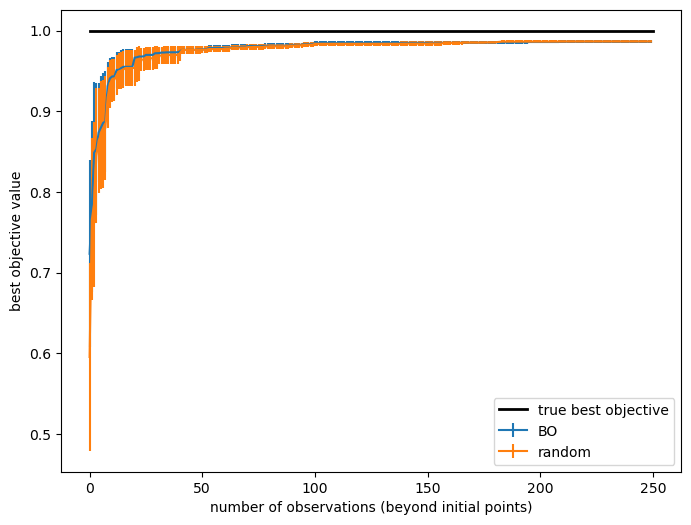

In [17]:
import numpy as np
from matplotlib import pyplot as plt


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

GLOBAL_MAXIMUM = 1
if USE_TEST_FUNCTION:
    GLOBAL_MAXIUM = 0



iters = np.arange(N_ITERATIONS)
y_random = np.asarray(best_random_all)
y_BO = np.asarray(best_BO_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(iters, y_BO.mean(axis=0), yerr=ci(y_BO), label="BO", linewidth=1.5)
ax.errorbar(iters, y_random.mean(axis=0), yerr=ci(y_random), label="random", linewidth=1.5)
plt.plot(
    [0, N_ITERATIONS],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
#ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")

In [18]:
y_BO

array([[0.71994304, 0.71994304, 0.86822148, ..., 0.9868884 , 0.9868884 ,
        0.9868884 ],
       [0.59237261, 0.94602869, 0.94602869, ..., 0.97881184, 0.97881184,
        0.97881184],
       [0.22256946, 0.22256946, 0.47887854, ..., 0.985149  , 0.985149  ,
        0.985149  ],
       ...,
       [0.88320881, 0.88320881, 0.88320881, ..., 0.99051044, 0.99051044,
        0.99051044],
       [0.95481047, 0.96998104, 0.96998104, ..., 0.98933654, 0.98933654,
        0.98933654],
       [0.86921409, 0.86921409, 0.86921409, ..., 0.98713094, 0.98713094,
        0.98713094]])

In [19]:
y_random

array([[0.15775769, 0.67543309, 0.67543309, ..., 0.98539954, 0.98539954,
        0.98539954],
       [0.58253855, 0.95293268, 0.95293268, ..., 0.98232062, 0.98232062,
        0.98232062],
       [0.20735001, 0.25832452, 0.25832452, ..., 0.98367772, 0.98367772,
        0.98367772],
       ...,
       [0.4076645 , 0.71832701, 0.71832701, ..., 0.99060159, 0.99060159,
        0.99060159],
       [0.50304869, 0.95737429, 0.97098079, ..., 0.99078869, 0.99078869,
        0.99078869],
       [0.92327805, 0.92327805, 0.92327805, ..., 0.98718522, 0.98718522,
        0.98718522]])

In [20]:
cam.close()

In [21]:
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
A0 = np.array([[random_PWM[0]], [random_PWM[1]], [random_PWM[2]], [random_PWM[3]], [random_PWM[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A0)
print(f"The original PWM randomly set by {random_PWM_printed} with score {s1}")

optimal_pwm_values=best_BO_params
A1= np.array([[optimal_pwm_values[0]], [optimal_pwm_values[1]], [optimal_pwm_values[2]], [optimal_pwm_values[3]], [optimal_pwm_values[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A1)
raw_image_array1 = cam.grab(10) # grab 10 frames
image_array1=np.array(raw_image_array1)
squeezed_image_array1=image_array1.squeeze()
print(f"The suggested PWM values for correction is {optimal_pwm_values} with score {best_BO_value}")
cam.close()

The original PWM randomly set by [2459, 438, 2498, 2387, 1937] with score 0.4023658264452383
The suggested PWM values for correction is [tensor(1199.), tensor(1160.), tensor(953.), tensor(880.), tensor(200.)] with score 0.9871309386595118


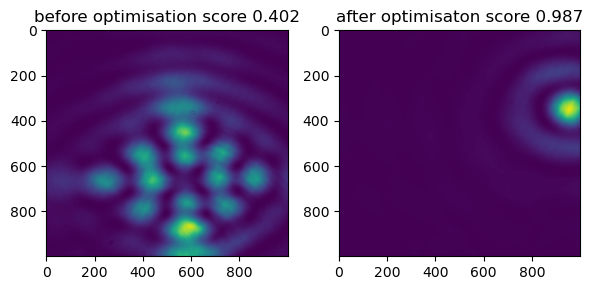

In [22]:
rows = 1
columns = 2
fig, (ax1, ax2) = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))
ax1.imshow(image_array_initial[0], aspect='auto')
ax1.set_title(f'before optimisation score {s1:.3f}')
ax2.imshow(image_array1[0], aspect='auto')
ax2.set_title(f'after optimisaton score {best_BO_value:.3f}')
fig.tight_layout() # used to adjust padding between subplots 

In [23]:
cam.close()

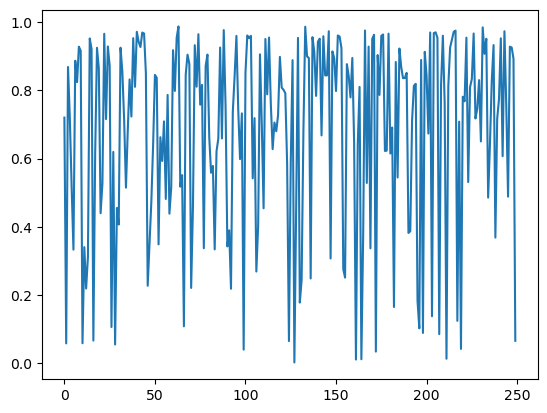

In [24]:
plt.plot(BO_trial_samples[0]["error"])